In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
!{sys.executable} -m pip install statsmodels
## Import statistical package for Vector ARIMA
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pickle
import numpy as np


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: C:\Users\danne\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Import the Datasets

In [2]:
dataset_paths = ["./USDCHF=X.csv", "./GC=F.csv", "./GSPC.csv", "./SSMI.csv"]
dataset_names = [path.split("./")[-1].split(".")[0] for path in dataset_paths]
# Remove =X from the name of USDCHF dataset
dataset_names[0] = dataset_names[0].split("=")[0]
datasets = {}
## Read in the datasets
for ds_name, ds_path in zip(dataset_names, dataset_paths):
    entire_dataset = pd.read_csv(ds_path, parse_dates=['Date'])
    # Drop all but the date and close columns
    datasets[ds_name] = entire_dataset[['Date', 'Close']]
print(dataset_names)

['USDCHF', 'GC=F', 'GSPC', 'SSMI']


### Join the Datasets

In [3]:
# Perform inner join to add the closing price for each dataset into a single df
merged_dataset = datasets[dataset_names[0]]
for ds_name in dataset_names[1:]:
    datasets[ds_name] = datasets[ds_name].rename(columns={"Close": ds_name})
    merged_dataset = merged_dataset.merge(datasets[ds_name], on='Date',how='inner')
merged_dataset = merged_dataset.rename(columns={"Gold_USD": "Gold_Price"})
print(f"USD/CHF after merge: {merged_dataset.shape}")
print(merged_dataset.head())

USD/CHF after merge: (247, 5)
        Date    Close         GC=F         GSPC          SSMI
0 2022-12-09  0.93586  1798.099976  3934.379883  11068.299805
1 2022-12-12  0.93499  1780.500000  3990.560059  11033.639648
2 2022-12-13  0.93574  1813.900024  4019.649902  11136.620117
3 2022-12-14  0.92898  1807.500000  3995.320068  11160.690430
4 2022-12-15  0.92435  1777.199951  3895.750000  10880.139648


### Test Stationary of the Time-Series Datasets

In [4]:
### Tests stationarity of a given signal using the adfuller test
def test_stationarity(time_series_ds, time_series_name, signif_threshold=0.05, ):
    print(f"\n\n\t\t Running Augmented Dickey-Fuller test on {time_series_name}")
    print("-"*80)
    adfuller_result = adfuller(time_series_ds, autolag='AIC')
    significance = round(adfuller_result[1], 5)
    print(f"P-value: {significance}")
    if significance < signif_threshold:
        print(f"P-value less than {signif_threshold} threshold. Null hypothesis rejected")
        print("Provided Time-Series is Stationary")
    else: 
        print(f"P-value exceeds {signif_threshold}. There is insufficient evidence to reject the null hypothesis.")
        print(f"Provided Time-Series Assumed Non-Stationary")

In [5]:
## Run stationary test on training portion of each individual dataset
print(merged_dataset)
print(f"dataset names:  {dataset_names}")
for col_name in merged_dataset.columns:
    if col_name != "Date":
        next_time_series = merged_dataset[col_name]
        test_stationarity(next_time_series, col_name)

          Date     Close         GC=F         GSPC          SSMI
0   2022-12-09  0.935860  1798.099976  3934.379883  11068.299805
1   2022-12-12  0.934990  1780.500000  3990.560059  11033.639648
2   2022-12-13  0.935740  1813.900024  4019.649902  11136.620117
3   2022-12-14  0.928980  1807.500000  3995.320068  11160.690430
4   2022-12-15  0.924350  1777.199951  3895.750000  10880.139648
..         ...       ...          ...          ...           ...
242 2023-12-04  0.867850  2024.099976  4569.779785  10952.440430
243 2023-12-05  0.872510  2018.500000  4567.180176  10964.809570
244 2023-12-06  0.874936  2030.500000  4549.339844  11001.620117
245 2023-12-07  0.874640  2029.900024  4585.589844  10968.099609
246 2023-12-08  0.879840  1998.300049  4604.370117  11071.769531

[247 rows x 5 columns]
dataset names:  ['USDCHF', 'GC=F', 'GSPC', 'SSMI']


		 Running Augmented Dickey-Fuller test on Close
--------------------------------------------------------------------------------
P-value: 0.28

### Perform Differencing to Enforce Stationarity

In [6]:
df = merged_dataset.copy()
days_to_forecast = 5
train= df[:-days_to_forecast].reset_index(drop=True)
test= df[-days_to_forecast:].reset_index(drop=True)
train_data = df.drop(['Date'], axis=1)

## Difference the test and training set
diff_train = diff(train_data, k_diff=1).dropna()
# Extra day needed as start of testing set for differencing
diff_test = diff(df[-(days_to_forecast+1):])
diff_entire = diff(df, k_diff=1).dropna()


### Check that all Time-series are now all Stationary

In [7]:
## Run stationary test on training portion of each individual dataset
print(merged_dataset)
for col_name in merged_dataset.columns:
    if col_name != "Date":
        next_time_series = merged_dataset[col_name]
        test_stationarity(next_time_series, col_name)

          Date     Close         GC=F         GSPC          SSMI
0   2022-12-09  0.935860  1798.099976  3934.379883  11068.299805
1   2022-12-12  0.934990  1780.500000  3990.560059  11033.639648
2   2022-12-13  0.935740  1813.900024  4019.649902  11136.620117
3   2022-12-14  0.928980  1807.500000  3995.320068  11160.690430
4   2022-12-15  0.924350  1777.199951  3895.750000  10880.139648
..         ...       ...          ...          ...           ...
242 2023-12-04  0.867850  2024.099976  4569.779785  10952.440430
243 2023-12-05  0.872510  2018.500000  4567.180176  10964.809570
244 2023-12-06  0.874936  2030.500000  4549.339844  11001.620117
245 2023-12-07  0.874640  2029.900024  4585.589844  10968.099609
246 2023-12-08  0.879840  1998.300049  4604.370117  11071.769531

[247 rows x 5 columns]


		 Running Augmented Dickey-Fuller test on Close
--------------------------------------------------------------------------------
P-value: 0.28295
P-value exceeds 0.05. There is insufficient evi

### Test Causality between the Various Time Series

In [8]:
def grangers_causation_matrix(data, variables, maxlag = 15, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [9]:
diff_no_date= diff_entire.drop(["Date"], axis=1)
grangers_causation_matrix(diff_no_date, variables = diff_no_date.columns)

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is d

,Close_x,GC=F_x,GSPC_x,SSMI_x
Close_y,1.0000,0.0000,0.0000,0.4391
GC=F_y,0.0047,1.0000,0.0137,0.2458
GSPC_y,0.0154,0.0318,1.0000,0.1326
SSMI_y,0.0693,0.0128,0.0000,1.0000


## Autocorrelograms

In [10]:
def plot_autocorrelograms(df,var):
    plot_acf(df[var].dropna(),lags=20)
    plt.title(f"Autocorrelation for {var}")
    plot_pacf(df[var].dropna(),lags=20)
    plt.title(f"Partial Autocorrelation for {var}")

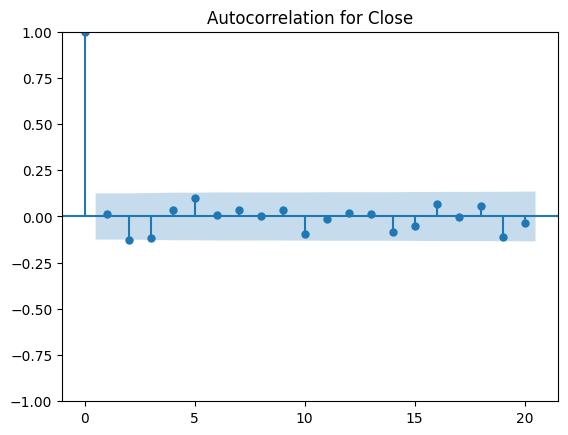

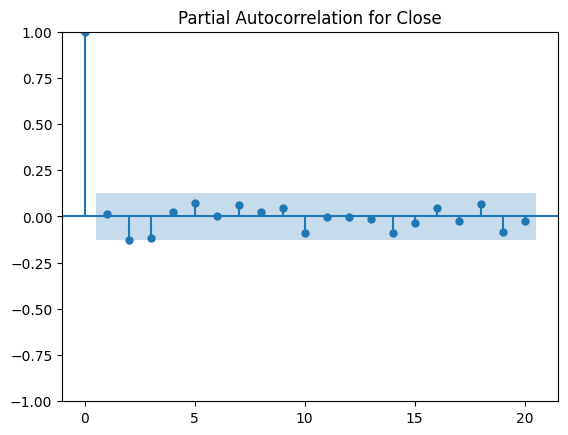

In [11]:
plot_autocorrelograms(diff_entire,'Close')

### Train the Model with Only Endogenous Variables

In [12]:
p = np.arange(1,6)
q = np.arange(1,6)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        model = VARMAX(diff_train, order=(i,j), seasonal_order=(0,0,0,0), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse')
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = train_data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5).reset_index(drop=True).Close)
        pred['observed'] = test.Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_order', 'mle_regression']).Passing unknown keyword arguments will raise a TypeError b

In [13]:
print(MSEs)

[8.95127749214097e-05, 8.51927351522383e-05, 8.243137134391311e-05, 8.109578195870247e-05, 1.1528275456498473e+23, 25112.91794882878, 8.415646794379049e-05, 8.716603398989059e-05, 8.728436421373353e-05, 2.7725854030248582, 8.416229077781385e-05, 4880064.538554, 27725.662404019862, 8.404628988423789e-05, 61.84642076646139, 8.410184051055135e-05, 8.42944557632727e-05, 8.276949102631509e-05, 8.58299443667191e-05, 4.951117602872954e+22, 3306.445994982661, 0.00010560293848987956, 2666.5234631241537, 1195999.9202430553, 7.897898307981636e+26]


##### Extract the Model with Lowest MSE on Training Set

In [17]:
print(orders[np.argmin(MSEs)])
model_fit_orig= models[np.argmin(MSEs)]
optimal_order = orders[np.argmin(MSEs)]

(1, 4)


#### Plot the Predictions vs. Observations

In [18]:
# plot prediction vs observed
def plot_predictions(train_set, test_set, model_fit, exog_feat=None):
    pred = pd.DataFrame()
    if exog_feat is None:
        pred['prediction'] = train_set.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5).reset_index(drop=True).Close)
    else:
        pred['prediction'] = train_set.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=test_set[exog_feat]).reset_index(drop=True).Close)
    pred['observed'] = test_set.Close
    pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])
    plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")
    return pred

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


   prediction  observed
0    0.883003  0.867850
1    0.882963  0.872510
2    0.880607  0.874936
3    0.880383  0.874640
4    0.881047  0.879840


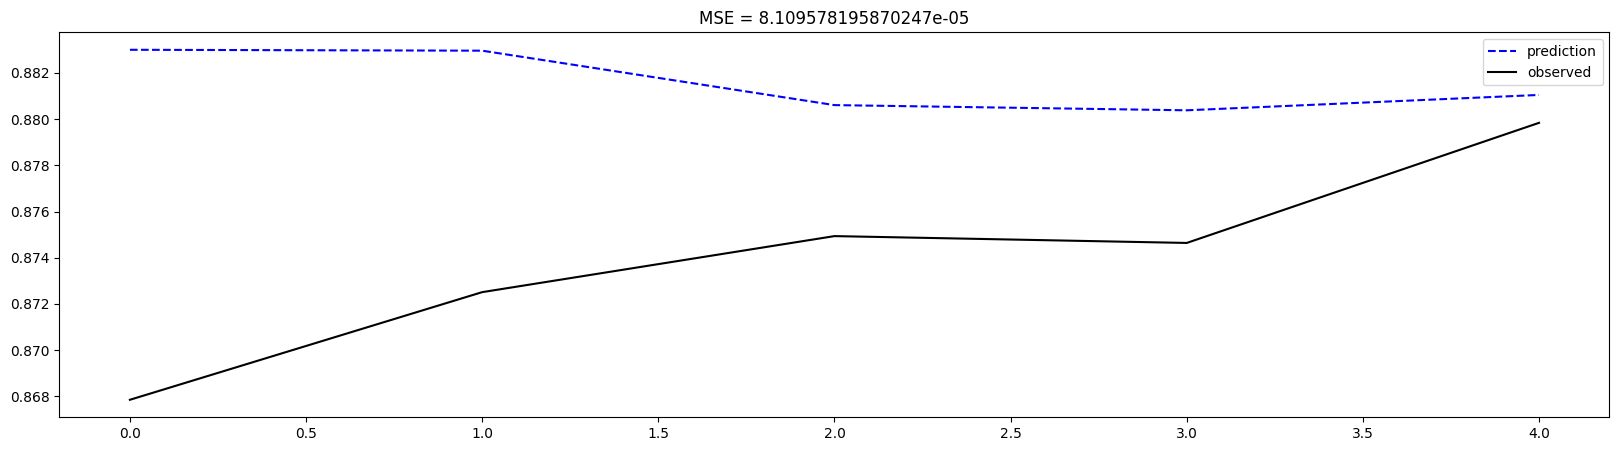

In [19]:
pred_array = plot_predictions(train_data, test, model_fit_orig)
print(pred_array)
predicted_values = pred_array['prediction']
predicted_values.to_csv('USD-CHF_endog_preds.csv', sep=',')

## Forecast predictions on the future 5 days

### Retrain a model on the entire training set

In [20]:
model = VARMAX(diff_train, order=optimal_order, seasonal_order=(0,0,0,0), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse')
model_fit_final = model.fit(disp=False)

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_order', 'mle_regression']).Passing unknown keyword arguments will raise a TypeError b

#### Forecast on future 5 days

In [21]:
five_day_forecast = df.iloc[-1]['Close'] + np.cumsum(model_fit_final.forecast(5).reset_index(drop=True).Close)
print(five_day_forecast)

0    0.883003
1    0.882963
2    0.880607
3    0.880383
4    0.881047
Name: Close, dtype: float64


C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [22]:
five_day_forecast.to_csv("USD-CHF-Forecast.csv", sep=",")

##### Save the Best model

In [23]:
pickle.dump(model_fit, open(f"./usd_chf_models/model_{optimal_order[0]}_{optimal_order[1]}_best.pkl","wb"))